### Notebook that calculate the number of driver mutations per sample in degrons. It uses the output of degron-dndscv and the output of normal dndscv

### Read data 

In [1]:
import pandas as pd
import numpy as np
import os
import re
import glob
import json
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection
import numpy as np, scipy.stats as st
import itertools


### paths

In [2]:
base = "../../"
# Path outputs dndscv
path_dndscv =os.path.join(base,"driver_mutations","excess_degrons","degron-dndscv","results","whole_genes")
path_dndscv_degron =os.path.join(base,"driver_mutations","excess_degrons","degron-dndscv","results","degrons")
re_dnds = "*.results.table.tsv"
re_dnds_in = "*.tsv.gz"
re_dnds_annomuts = "*annotmuts_degron.out.gz"
# Path dictionary
path_dictionary_samples = os.path.join(base,"data","dict_excess_per_sample_degrons.json")
# Path driver degrons
output_combined_information = os.path.join(base,"data","table_positive_selection.tsv.gz")
path_output_drivers_strict_tcga = os.path.join(base,"data","list_drivers_degrons_strict_tcga.txt")

# Plots 
path_output_plots = os.path.join(base,"plots","Figure7")
# Path input mutations 
path_input_muts = os.path.join(base,"data","mutations_e3","tcga")

In [3]:
import re

def read_drivers(file_path):
    f = open(file_path,'r')
    drivers = set()
    for line in f.readlines():
        line = line.strip()
        for gene in re.split(r'\t+', line):
            drivers.add(gene)
    f.close()
    return drivers
drivers=read_drivers(path_output_drivers_strict_tcga)

### Read output of dndscv and get the global value of dndscv

##### Functions to calculate excess from omega

In [4]:
def excess_muts(n_obs, omega):
    """
    n_obs: int: number of observed mutations of a kind
    omega: float: applicable dnds estimate
    omega: float: applicable dnds estimate
    """
    if (n_obs == 0) or np.isnan(n_obs) or np.isnan(omega):
        return n_obs
    elif 0 <= omega <= 1:
        return 0
    elif omega > 1:
        return round((omega - 1) * n_obs / omega)

def excess_rate(n_obs, omega):
    """
    n_obs: int: number of observed mutations of a kind
    omega: float: applicable dnds estimate
    """
    if (n_obs == 0) or np.isnan(n_obs) or np.isnan(omega):
        return 0
    elif 0 <= omega <= 1:
        return 0
    elif omega > 1:
        return (omega - 1) / omega

def add_excess(df):
    
    df['excess_mis'] = df.apply(lambda v: excess_muts(v['n_mis_degron'], v['wmis_degron']), axis=1)
    df['excess_rate_mis'] = df.apply(lambda v: excess_rate(v['n_mis_degron'], v['wmis_degron']), axis=1)

    return df


### Calculate the excess per cohort per gene

In [5]:
l = []
for filef in glob.glob(path_dndscv_degron+"/"+re_dnds):
    if "annotmuts" in filef or "genemuts" in filef:
        continue
    df = pd.read_csv(filef,sep="\t")
    ttype = os.path.basename(filef).split(".")[0]
    df["Cancer_Type"]=ttype
    df = df[df["gene"].isin(drivers)][['gene', 'nmis_gene', 'nmis_dc', 'wmis_degron','Cancer_Type']].drop_duplicates()
    df["n_mis_degron"] = df.apply(lambda row: row["nmis_gene"] - row["nmis_dc"],axis=1)
    #df.rename(columns={"qglobal_cv":"dndscv_qvalue","gene_name":"Hugo_Symbol"},inplace=True)
    l.append(df)
df_dnds = pd.concat(l)
df_with_excess = add_excess(df_dnds)

### Dictionaries to speed up the calculation of sample-specific excess

In [6]:
dict_missense = {}
dict_non = {}
dict_splice = {}
d_global = {}
for index,row in df_with_excess.iterrows():
    dict_missense[row["gene"]+"_"+row["Cancer_Type"]] = row["excess_rate_mis"]

d_global["Missense"] = dict_missense

### Number of samples per ttype

In [7]:
dict_samples= {}
for filef in glob.glob(path_input_muts+"/"+"*_dndscv.tsv.gz"):
    df = pd.read_csv(filef,sep="\t",compression="gzip")
    ttype = os.path.basename(filef).split(".")[0].split("_")[0]
    df["Cancer_Type"]=ttype
    dict_samples[ttype]=len(df["sampleID"].unique())

### Calculate for each sample the number of driver mutations (number of mutations in excess). Calculate per consequence type and the agggregated one

##### Functions to calculate it

In [8]:
def get_excess_sample(df_grouped,impact,total_samples,ttype,dict_output,dict_samples):
    '''
    df_grouped : dataframe input with the excess grouped by sample, gene and impact. The column pos has the number of mutations per gene per sample. 
    impact: consequence type ["Missense","Nonsense","Essential_Splice"]
    total_samples: total number of samples in this cohrot
    ttype: cancer type
    dict_output: dictionary to fill with the excess of the impact type for this cohort
    dict_samples: diciontary where keys are ttype and samples where its calculated the global excess (excess of mis) per sample 
    '''
    df_data = df_grouped[df_grouped["impact"]==impact]

    excess_array = []
    if df_data.shape[0] >0:
        
        # calculate excess as excess_rate * number of mutations per gene per sample
        
        df_data["excess"]=df_data.apply(lambda row: row["pos"]*d_global[impact][row["gene"]+"_"+row["Cancer_Type"]] if row["gene"]+"_"+row["Cancer_Type"]  in d_global[impact] else 0.0,axis=1)
        # get sum of missense in excess per sample
        excess_array = list(df_data.groupby("sampleID",as_index=False).agg({"excess":np.nansum})["excess"].values)
        samples = list(df_data.groupby("sampleID",as_index=False).agg({"excess":np.nansum})["sampleID"].values)
        for i in range(0,len(samples)):
            sample = samples[i]
            if sample in dict_samples[ttype]:
                dict_samples[ttype][sample] =  dict_samples[ttype][sample] + excess_array[i]
            else:
                dict_samples[ttype][sample] =  excess_array[i]
        
    # if there is not information is a 0
    zeros = list(np.zeros(total_samples-len(excess_array)))
    total_cohort = zeros +  excess_array
    if not(ttype in dict_output):
        dict_output[ttype]= []
    dict_output[ttype] = dict_output[ttype] + total_cohort
    return dict_output,dict_samples

### Perform the calculation for all tumor types

In [9]:
dict_excess_sample_missense = {}
dict_excess_sample_aggregated = {}
dict_samples_local = {}
for filef in glob.glob(path_dndscv+"/"+re_dnds_annomuts):
    ttype = os.path.basename(filef).split(".")[0].split("_")[0]
    df = pd.read_csv(filef,sep="\t",compression="gzip")
    df = df[(df["gene"].isin(drivers))&(df["degron"]!="-")]
    df["Cancer_Type"]=ttype
    if ttype == "COAD" or ttype == "READ":
        continue # Its grouped in COADREAD
    # Get total number of samples
    total_samples = dict_samples[ttype]
    
    dict_samples_local[ttype] = {}
    # Group per sample and gene
    df_grouped = df.groupby(["Cancer_Type","gene","sampleID","impact"],as_index=False).agg({"pos":"count"}) # count mutations in gene per sample
    # Missense
    dict_excess_sample_missense,dict_samples_local=get_excess_sample(df_grouped,"Missense",total_samples,ttype,dict_excess_sample_missense,dict_samples_local)
    
    # dict aggregated
    excess_aggregated_data = list(dict_samples_local[ttype].values())
    zeros = list(np.zeros(total_samples-len(excess_aggregated_data)))
    dict_excess_sample_aggregated[ttype] = list(excess_aggregated_data) + zeros

    


/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


##### save a dictionary per sample

In [10]:
json.dump(dict_samples_local,open(path_dictionary_samples,'w'))

In [11]:
for ttype in dict_excess_sample_aggregated.keys():
    aggregated = np.nanmean(dict_excess_sample_aggregated[ttype])
    mis = np.nanmean(dict_excess_sample_missense[ttype])
    print (ttype,aggregated,mis,)

ACC 0.11906798954196614 0.11906798954196614
BLCA 0.0728053454272714 0.0728053454272714
BRCA 0.005880892639741762 0.005880892639741762
CHOL 0.16499999999999998 0.16499999999999998
CESC 0.12362695410641358 0.12362695410641361
COADREAD 0.05739426297656264 0.05739426297656264
DLBC 0.0 0.0
ESCA 0.10591597398155754 0.10591597398155754
GBM 0.002412913838847275 0.002412913838847275
HNSC 0.08126521160695467 0.08126521160695467
KICH 0.0 0.0
KIRC 0.016141304347826086 0.016141304347826086
KIRP 0.05062284337532406 0.05062284337532406
LGG 0.007764705882352941 0.007764705882352941
LIHC 0.2573720753521973 0.2573720753521973
LUAD 0.07387239856914066 0.07387239856914067
LUSC 0.15971605503984998 0.15971605503984998
MESO 0.010936473477022354 0.010936473477022354
OV 0.0 0.0
PAAD 0.02188646129332179 0.02188646129332179
PAN 0.06154694596519554 0.061546945965195526
PCPG 0.04424581005586592 0.044245810055865926
PRAD 0.02004048582995951 0.020040485829959515
SARC 0.01532714347303823 0.01532714347303823
SKCM 0.07

### Tumor type analysis

##### Function to calculate the ci (0.95)

In [12]:
def get_ci95(grp):
    return st.t.interval(0.95, len(grp)-1, loc=np.mean(grp), scale=st.sem(grp))

### Plot it for each tumor type

/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1984: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


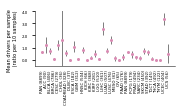

In [15]:
order = ["PAN"]+sorted(list(dict_excess_sample_aggregated.keys())[:-1])
values = []
ci_ls = []
ci_us = []
for ttype in order:
    mean_excess = np.nanmean(dict_excess_sample_aggregated[ttype])
    values.append(mean_excess)
    ci = get_ci95(dict_excess_sample_aggregated[ttype])
    ci_l = ci[0]
    ci_ls.append(mean_excess-ci_l)
    ci_u = ci[1]
    ci_us.append(ci_u-mean_excess)
fig,ax = plt.subplots(figsize=(2.5,1))
xs = range(0,len(order))
ax.set_ylim(-0.05,0.4)
ax.errorbar(xs, values, yerr=[ci_ls,ci_us], ecolor='grey', capthick=5,fmt='o',elinewidth=1,markersize=2,c="#d98cb3" )
#ax.scatter(x=xs,y=values,s=5)
ax.set_xticks(xs)
labels = [x+f" ({len(dict_excess_sample_aggregated[x])})" for x in order]
_=ax.set_xticklabels(labels,fontsize=5,rotation=90)
ax.set_yticks(np.arange(0,0.5,0.1))
ax.set_yticklabels(["{:.1f}".format(x*10) for x in np.arange(0,0.5,0.1)],fontsize=4,)
ax.set_ylabel("Mean drivers per sample \n (ratio per 10 samples)",fontsize=5)
ax.spines['top'].set_linewidth(0.0)
ax.spines['right'].set_linewidth(0.0)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.01 ,width=0.0)
plt.savefig(os.path.join(path_output_plots,"n_drivers_per_tumor_degron.pdf"),bbox_inches="tight",dpi=100)

### Global analysis

In [14]:
missense_drivers = list(dict_excess_sample_missense.values())
mean_missense = np.nanmean(list(itertools.chain(*missense_drivers)))
ci_l_m,ci_u_m = get_ci95(list(itertools.chain(*missense_drivers)))

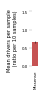

In [23]:
fig,ax = plt.subplots(figsize=(0.12,1.0))
ax.bar(x=0,bottom=0,height=mean_missense,color="#c65353",lw=0.5,yerr=[[mean_missense-ci_l_m,ci_u_m-mean_missense]],error_kw={"linewidth":0.5})


ax.set_yticks([x for x in np.arange(0,0.20,0.05)])
ax.set_yticklabels(["{:.1f}".format(x*10)  for x in np.arange(0,0.20,0.05)],fontsize=4)
ax.set_ylabel("Mean drivers per sample \n (ratio per 10 samples)",fontsize=5)
ax.set_xlabel("",fontsize=5)
ax.set_xticks([0])
ax.set_xticklabels(["Missense"],fontsize=5,rotation=90)
ax.spines['top'].set_linewidth(0.0)
ax.spines['right'].set_linewidth(0.0)
ax.spines['left'].set_linewidth(0.0)
ax.spines['bottom'].set_linewidth(0.0)
ax.tick_params(axis = 'y', labelsize =4  , pad=0.15 ,width=0.15)
ax.tick_params(axis = 'x', labelsize =4  , pad=0.05 ,width=0.0)
plt.savefig(os.path.join(path_output_plots,"number_drivers_average_degron.pdf"),bbox_inches="tight",dpi=100)
None

None